### Test I: Layout Organization Recognition – RenAIssance Project
Dataset Description:
- The dataset provided consists of 6 scanned early modern printed sources, each - stored as a separate PDF file. These sources contain:
- OCR-applied text with recognition limitations (e.g., missing letters, incorrect words).
- Editable PDFs which were converted to JPEG images for processing.
- Transcriptions of the first 3 pages per source, which served as reference text.
- Additional untranscribed pages for model evaluation.

Project Goal: The project aimed to detect and classify layout elements (e.g., main_text, heading, drop_cap, author) from historical document scans—particularly early modern printed sources. This was part of the RenAIssance Project Test I: Layout Organization Recognition for GSoC 2025.

Model and Approach:
- Utilized a YOLOv8 object detection model with fine-tuning on a custom annotated dataset.
- Dataset included multiple layout classes such as main_text, heading, drop_cap, and author.
- Training was performed over 50 epochs, with careful monitoring of losses and evaluation metrics.
- Data was formatted in YOLOv8 and trained using augmentation strategies.


Checking GPU Availability

In [ ]:
!nvidia-smi

Sat Apr  5 05:16:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Installing Required Libraries

In [ ]:
!pip install pymupdf
!pip install ultralytics torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

Importing Required Libraries

In [ ]:
import os
from PIL import Image
import fitz
from ultralytics import YOLO
import torch
import pandas as pd
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Converting All PDF Pages to Images

In [ ]:
pdf_directory = "/content/drive/MyDrive/Lor_YOLO/Pdfs"
image_directory = "/content/drive/MyDrive/Lor_YOLO/pdf_images/"
os.makedirs(image_directory, exist_ok=True)
for filename in os.listdir(pdf_directory):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(pdf_directory, filename)
        try:
            doc = fitz.open(pdf_path)
            for page_num in range(doc.page_count):
                page = doc[page_num]
                pix = page.get_pixmap(matrix=fitz.Matrix(100 / 72, 100 / 72), dpi=100)
                img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
                img = img.resize((640, 640))
                image_path = os.path.join(image_directory, f"{filename[:-4]}_page_{page_num + 1}.png")
                img.save(image_path, "PNG")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

#### Annotating Document Layouts with Roboflow

After converting PDF pages into uniformly sized PNG images (640×640), the next essential step involved annotating document elements using Roboflow.

Defined Classes: The following four classes were used to annotate key components of each historical document layout:
- author: Name or attribution text typically found at the start or end of texts.
- drop_cap: Stylized, oversized letters at the beginning of paragraphs.
- heading: Section or chapter titles.
- main_text: The primary body of content on each page (core focus of Test I).

#### Defining Training Configuration
- To maintain a clean and modular codebase, a configuration class Config was created to store all important file paths and hyperparameters used during model training. This setup allows easy adjustment of parameters and reusability across experiments.

In [ ]:
class Config:
    TRAIN_PATH = '/content/drive/MyDrive/Lor_YOLO/yolo/train'
    VALID_PATH = '/content/drive/MyDrive/Lor_YOLO/yolo/valid'
    TEST_PATH  = '/content/drive/MyDrive/Lor_YOLO/yolo/test'
    DATA_YAML  = '/content/drive/MyDrive/Lor_YOLO/yolo/data.yaml'

    MODEL_TYPE = 'yolov8m.pt'

    # Training Hyperparameters
    EPOCHS = 50
    IMAGE_SIZE = 640
    BATCH_SIZE = 16
    PATIENCE = 20
    LR0 = 0.01
    LRF = 0.01
    MOMENTUM = 0.937
    WEIGHT_DECAY = 0.0005
    WARMUP_EPOCHS = 3.0
    WARMUP_BIASE_LR = 0.1
    FLIPUD = 0.0
    FLIPLR = 0.5
    HSV_H = 0.015
    HSV_S = 0.7
    HSV_V = 0.4
    MIXUP = 0.0
    MOSAIC = 1.0
    COPY_PASTE = 0.0
    WORKERS = 8
    PROJECT_DIR = '/content/drive/MyDrive/Lor_YOLO/yolo/runs'
    EXPERIMENT_NAME = 'layout_detection_gpu'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

ensuring that all the required path exists.

In [ ]:
def verify_paths():
    assert os.path.exists(Config.DATA_YAML), f"Missing data.yaml at {Config.DATA_YAML}"
    assert os.path.exists(Config.TRAIN_PATH), f"Missing train folder"
    assert os.path.exists(Config.VALID_PATH), f"Missing valid folder"
    print("[INFO] All paths verified.")
    print(f"[INFO] Using device: {Config.DEVICE}")

This function is responsible for training the YOLOv8 model using the dataset and training hyperparameters specified in the Config class.
- Loads the YOLO model architecture (e.g., yolov8m.pt)
-Trains the model using:
  
  - The dataset defined in data.yaml
  - Customizable parameters: learning rate, image size, batch size, augmentations, etc.
  - GPU acceleration (if available)

- Logs the progress and saves all training artifacts (metrics, weights, logs) in the specified directory.

In [ ]:
def train_model():
    print("[INFO] Loading model:", Config.MODEL_TYPE)
    model = YOLO(Config.MODEL_TYPE)

    print("[INFO] Starting training on GPU...")
    model.train(
        data=Config.DATA_YAML,
        epochs=Config.EPOCHS,
        imgsz=Config.IMAGE_SIZE,
        batch=Config.BATCH_SIZE,
        patience=Config.PATIENCE,
        lr0=Config.LR0,
        lrf=Config.LRF,
        momentum=Config.MOMENTUM,
        weight_decay=Config.WEIGHT_DECAY,
        warmup_epochs=Config.WARMUP_EPOCHS,
        warmup_bias_lr=Config.WARMUP_BIASE_LR,
        flipud=Config.FLIPUD,
        fliplr=Config.FLIPLR,
        hsv_h=Config.HSV_H,
        hsv_s=Config.HSV_S,
        hsv_v=Config.HSV_V,
        mixup=Config.MIXUP,
        mosaic=Config.MOSAIC,
        copy_paste=Config.COPY_PASTE,
        workers=Config.WORKERS,
        device=Config.DEVICE,
        project=Config.PROJECT_DIR,
        name=Config.EXPERIMENT_NAME,
        verbose=True
    )
    print(f"[SUCCESS] Training complete. Results saved to {Config.PROJECT_DIR}/{Config.EXPERIMENT_NAME}/")

Executing the path verification and model training.

In [ ]:
if __name__ == "__main__":
    verify_paths()
    train_model()

[INFO] All paths verified.
[INFO] Using device: cuda
[INFO] Loading model: yolov8m.pt


100%|██████████| 49.7M/49.7M [00:01<00:00, 45.4MB/s]


[INFO] Starting training on GPU...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/Lor_YOLO/yolo/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/Lor_YOLO/yolo/runs, name=layout_detection_gpu, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

100%|██████████| 755k/755k [00:00<00:00, 112MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 268MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/1xtGHhzMnvJSXepELtdBN8NSUoug3sSZ9/Lor_YOLO/yolo/train/labels... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [01:03<00:00,  1.33s/it]

train: New cache created: /content/drive/.shortcut-targets-by-id/1xtGHhzMnvJSXepELtdBN8NSUoug3sSZ9/Lor_YOLO/yolo/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/.shortcut-targets-by-id/1xtGHhzMnvJSXepELtdBN8NSUoug3sSZ9/Lor_YOLO/yolo/valid/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:08<00:00,  1.39s/it]

val: New cache created: /content/drive/.shortcut-targets-by-id/1xtGHhzMnvJSXepELtdBN8NSUoug3sSZ9/Lor_YOLO/yolo/valid/labels.cache


Plotting labels to /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.32G      1.848      3.901      1.854        175        640: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          6         17    0.00296       0.25     0.0126     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.34G       2.12      4.084      2.011        127        640: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all          6         17    0.00327       0.25    0.00691    0.00574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.38G      1.937      3.089      1.862        156        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all          6         17      0.204      0.458      0.311      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.45G      1.273      1.994      1.422        125        640: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all          6         17       0.74      0.333      0.153     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.52G      1.255      1.692      1.327        127        640: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all          6         17      0.723      0.392       0.38      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.58G      1.083      1.418      1.234        127        640: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all          6         17      0.677      0.542      0.501      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.79G      1.048      1.361      1.186        174        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all          6         17       0.87      0.417      0.633      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.95G     0.9474      1.157      1.144        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all          6         17      0.824      0.486      0.568      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.06G     0.9258      1.158      1.116        151        640: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all          6         17      0.411      0.742      0.634      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.25G     0.9152      1.105      1.106        119        640: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all          6         17      0.555      0.762       0.75      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.32G     0.9391      1.047      1.139        129        640: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all          6         17      0.627      0.766      0.858      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       7.6G     0.8682     0.9882      1.108        117        640: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all          6         17      0.749      0.875      0.901      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.66G     0.9773      1.184      1.166        150        640: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all          6         17      0.586      0.725      0.778      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       7.9G     0.9355      1.023      1.132        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all          6         17      0.382      0.875      0.649      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.97G      0.887      0.993       1.11        137        640: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all          6         17      0.667      0.517        0.5      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.18G      0.922      1.015      1.126        107        640: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          6         17      0.748      0.542      0.602      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.24G      0.893     0.9702      1.099        148        640: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all          6         17      0.972      0.408      0.595      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.53G     0.9208      1.023      1.128        174        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all          6         17      0.636      0.804      0.727      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       8.6G     0.8656      0.939      1.085        140        640: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all          6         17      0.646      0.816      0.874      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.71G     0.9083      0.886      1.139         97        640: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all          6         17      0.564      0.904      0.823      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.86G     0.8939      1.025      1.137        144        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all          6         17      0.628       0.79      0.849      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.02G     0.8591     0.8556      1.079        127        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all          6         17      0.685      0.903      0.954      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.17G     0.8844     0.8537      1.074        158        640: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all          6         17      0.803          1      0.988      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.33G     0.8618     0.8821      1.096        142        640: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all          6         17      0.696      0.867       0.88      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       9.5G     0.9195     0.8471       1.09        154        640: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

                   all          6         17      0.619      0.903      0.806      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.61G     0.8456     0.9099      1.096        151        640: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all          6         17      0.618      0.605      0.735      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       9.8G     0.8801     0.8176      1.088        154        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all          6         17      0.711      0.718      0.754      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.91G     0.7558     0.7378      1.037        118        640: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all          6         17      0.617      0.875      0.881      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.1G     0.8171     0.7779      1.059        113        640: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all          6         17      0.617      0.875      0.881      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.2G     0.8387     0.7681      1.078        142        640: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all          6         17       0.76      0.837      0.906      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.4G     0.7649      0.727      1.053        124        640: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


                   all          6         17      0.678       0.87      0.873      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.5G     0.7782     0.7326      1.048        117        640: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all          6         17      0.845      0.768      0.953      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.7G     0.7694     0.7018      1.038        129        640: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all          6         17      0.845      0.768      0.953      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.8G     0.8027     0.7321      1.049        152        640: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all          6         17      0.795      0.896      0.995      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.9G     0.7262     0.6877          1        159        640: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all          6         17      0.912        0.8       0.96      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.2G     0.7275      0.682      1.062        111        640: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all          6         17      0.927      0.832      0.972      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.3G     0.7363     0.6809      1.034        160        640: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all          6         17      0.927      0.832      0.972      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.4G     0.7415     0.6734      1.015        114        640: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all          6         17      0.792      0.895      0.933      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.6G     0.7183     0.7049      1.039        125        640: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


                   all          6         17      0.826       0.86      0.933      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.7G     0.7143     0.6168       1.01        165        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all          6         17      0.816      0.842      0.933      0.725


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.9G     0.7681     0.8249      1.049         71        640: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all          6         17      0.816      0.842      0.933      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50        12G     0.7052     0.7241      1.031         70        640: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all          6         17      0.698      0.968      0.953      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.2G     0.7073     0.6626      1.025         68        640: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all          6         17      0.927      0.925      0.995       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      12.3G     0.6791     0.6228      1.025         81        640: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


                   all          6         17      0.915      0.983      0.995       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.5G     0.6711     0.6136      1.025         75        640: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all          6         17      0.915      0.983      0.995       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      12.8G     0.6574     0.5746      1.016         61        640: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]

                   all          6         17      0.888      0.951      0.995      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      12.8G     0.6639     0.6361      1.009         78        640: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all          6         17      0.936      0.909      0.995      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      12.9G     0.6171     0.5953     0.9597         68        640: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all          6         17      0.942      0.932      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.1G     0.5837     0.5398      1.002         42        640: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all          6         17      0.942      0.932      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      13.1G     0.6401     0.5417     0.9402         97        640: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all          6         17      0.926      0.987      0.995       0.75



50 epochs completed in 0.048 hours.
Optimizer stripped from /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


                   all          6         17      0.925      0.986      0.995       0.75
                author          2          3      0.956          1      0.995      0.722
              drop_cap          2          2      0.866          1      0.995      0.897
               heading          2          2          1      0.946      0.995      0.497
             main_text          6         10      0.879          1      0.995      0.884
Speed: 0.3ms preprocess, 15.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu
[SUCCESS] Training complete. Results saved to /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/


#### Evaluating the Model:
Model & Config Verification: Ensures weights and dataset configuration files exist.\
Model Loading: Initializes the YOLO model using the specified checkpoint (e.g., best.pt).\
Evaluation: Runs validation using YOLO’s built-in .val() method and returns comprehensive metrics.\

Output Metrics:
- mAP@0.5: Mean Average Precision at IoU threshold of 0.5.
- mAP@0.5:0.95: Averaged over thresholds from 0.5 to 0.95 (in steps of 0.05).
- Precision and Recall: Measure correctness and completeness of detection.
- F1 Score: Harmonic mean of precision and recall, indicating balanced performance.

In [ ]:
def evaluate_model():
    assert os.path.exists(Config.MODEL_WEIGHTS), f"Model weights not found at {Config.MODEL_WEIGHTS}"
    assert os.path.exists(Config.DATA_YAML), f"data.yaml not found at {Config.DATA_YAML}"

    print(f"[INFO] Loading model from: {Config.MODEL_WEIGHTS}")
    model = YOLO(Config.MODEL_WEIGHTS)

    print(f"[INFO] Running evaluation on device: {Config.DEVICE}")
    metrics = model.val(
        data=Config.DATA_YAML,
        imgsz=Config.IMAGE_SIZE,
        device=Config.DEVICE,
        split='val',
        save_json=True
    )

    box = metrics.box
    precision = box.mp
    recall = box.mr
    map50 = box.map50
    map5095 = box.map

    print("\n Evaluation Metrics:")
    print(f"  - mAP@0.5:       {map50:.4f}")
    print(f"  - mAP@0.5:0.95:  {map5095:.4f}")
    print(f"  - Precision:     {precision:.4f}")
    print(f"  - Recall:        {recall:.4f}")
    print(f"  - F1 Score:      {(2 * precision * recall) / (precision + recall + 1e-6):.4f}")

if __name__ == "__main__":
    evaluate_model()

[INFO] Loading model from: /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/weights/best.pt
[INFO] Running evaluation on device: cuda
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/drive/.shortcut-targets-by-id/1xtGHhzMnvJSXepELtdBN8NSUoug3sSZ9/Lor_YOLO/yolo/valid/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


                   all          6         17      0.926      0.986      0.995      0.742
                author          2          3      0.957          1      0.995       0.69
              drop_cap          2          2      0.866          1      0.995      0.897
               heading          2          2          1      0.946      0.995      0.497
             main_text          6         10      0.879          1      0.995      0.884
Speed: 0.3ms preprocess, 38.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving runs/detect/val4/predictions.json...
Results saved to runs/detect/val4

✅ Evaluation Metrics:
  - mAP@0.5:       0.9950
  - mAP@0.5:0.95:  0.7419
  - Precision:     0.9256
  - Recall:        0.9865
  - F1 Score:      0.9551


#### Model Evaluation Results

- After training the layout detection model using YOLOv8, we evaluated its performance on the validation set. The model checkpoint used was the `best.pt` file saved during training.  

#### Overall Performance
| Metric         | Value   |
|----------------|---------|
| mAP@0.5        | 0.9950  |
| mAP@0.5:0.95   | 0.7419  |
| Precision      | 0.9256  |
| Recall         | 0.9865  |
| F1 Score       | 0.9551  |

### Per-Class Results

| Class       | Precision | Recall | mAP@0.5 | mAP@0.5:0.95 |
|-------------|-----------|--------|---------|--------------|
| author      | 0.957     | 1.000  | 0.995   | 0.690        |
| drop_cap    | 0.866     | 1.000  | 0.995   | 0.897        |
| heading     | 1.000     | 0.946  | 0.995   | 0.497        |
| main_text   | 0.879     | 1.000  | 0.995   | 0.884        |


#### Summary
The YOLOv8 model demonstrates **excellent detection accuracy**, particularly for `main_text` and `drop_cap`. While `heading` has slightly lower mAP@0.5:0.95, the overall performance is strong, making this a reliable layout recognition model for early modern printed documents.

running inference on test image using trained yolov8 model.

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/weights/best.pt"
TEST_DIR = "/content/drive/MyDrive/Lor_YOLO/yolo/test/images"
SAVE_DIR = "/content/drive/MyDrive/Lor_YOLO/yolo/runs/test_predictions"
DEVICE = "cuda"
os.makedirs(SAVE_DIR, exist_ok=True)

def predict_on_test_images():
    print(f"[INFO] Loading model from: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)

    print(f"[INFO] Predicting on test images from: {TEST_DIR}")
    results = model.predict(
        source=TEST_DIR,
        device=DEVICE,
        save=True,
        save_txt=True,
        save_conf=True,
        imgsz=640,
        conf=0.25,
        iou=0.45,
        max_det=100,
        project=SAVE_DIR,  # Use custom directory directly
        name="",           # No subfolder, saves directly to SAVE_DIR
        exist_ok=True,
        verbose=True
    )

    print(f"[INFO] Predictions saved to: {SAVE_DIR}")

if __name__ == "__main__":
    predict_on_test_images()

[INFO] Loading model from: /content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/weights/best.pt
[INFO] Predicting on test images from: /content/drive/MyDrive/Lor_YOLO/yolo/test/images

image 1/3 /content/drive/MyDrive/Lor_YOLO/yolo/test/images/9_jpg.rf.d5fe472a41905123f32774dc61133f93.jpg: 640x640 5 main_texts, 37.1ms
image 2/3 /content/drive/MyDrive/Lor_YOLO/yolo/test/images/Constituciones-sinodales-Calahorra-1602_page-0006_jpg.rf.bab9f65804bbbaddc79dd361bd7f48c3.jpg: 640x640 1 drop_cap, 1 heading, 3 main_texts, 37.1ms
image 3/3 /content/drive/MyDrive/Lor_YOLO/yolo/test/images/Mendo-Principe-perfecto_page-0003_jpg.rf.3c9ddff757467e60c7cca6a8584d5ab1.jpg: 640x640 1 drop_cap, 1 heading, 2 main_texts, 37.2ms
Speed: 4.3ms preprocess, 37.1ms inference, 146.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/Lor_YOLO/yolo/runs/test_predictions/predict
3 labels saved to /content/drive/MyDrive/Lor_YOLO/yolo/runs/test_predictions/predict/labels

Displaying the predicted images

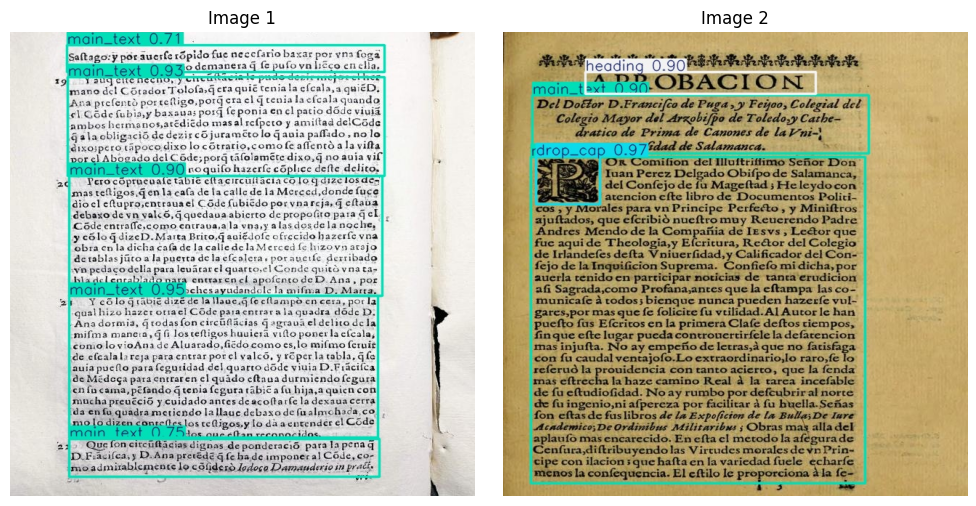

In [ ]:
image1 = Image.open('/content/drive/MyDrive/Lor_YOLO/yolo/runs/test_predictions/predict/9_jpg.rf.d5fe472a41905123f32774dc61133f93.jpg')
image2 = Image.open('/content/drive/MyDrive/Lor_YOLO/yolo/runs/test_predictions/predict/Mendo-Principe-perfecto_page-0003_jpg.rf.3c9ddff757467e60c7cca6a8584d5ab1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image1)
axes[0].axis('off')
axes[0].set_title('Image 1')

axes[1].imshow(image2)
axes[1].axis('off')
axes[1].set_title('Image 2')

plt.tight_layout()
plt.show()

#### Observations from predicted images:
- The model generalizes well across different fonts, layouts, and page structures.
- High confidence values suggest strong predictive power and well-learned features.
- YOLOv8's multi-class capability is demonstrated by simultaneous detection of multiple layout components.
- Bounding boxes do not overlap unnecessarily, preserving structural clarity.

#### Training & Validation Metrics

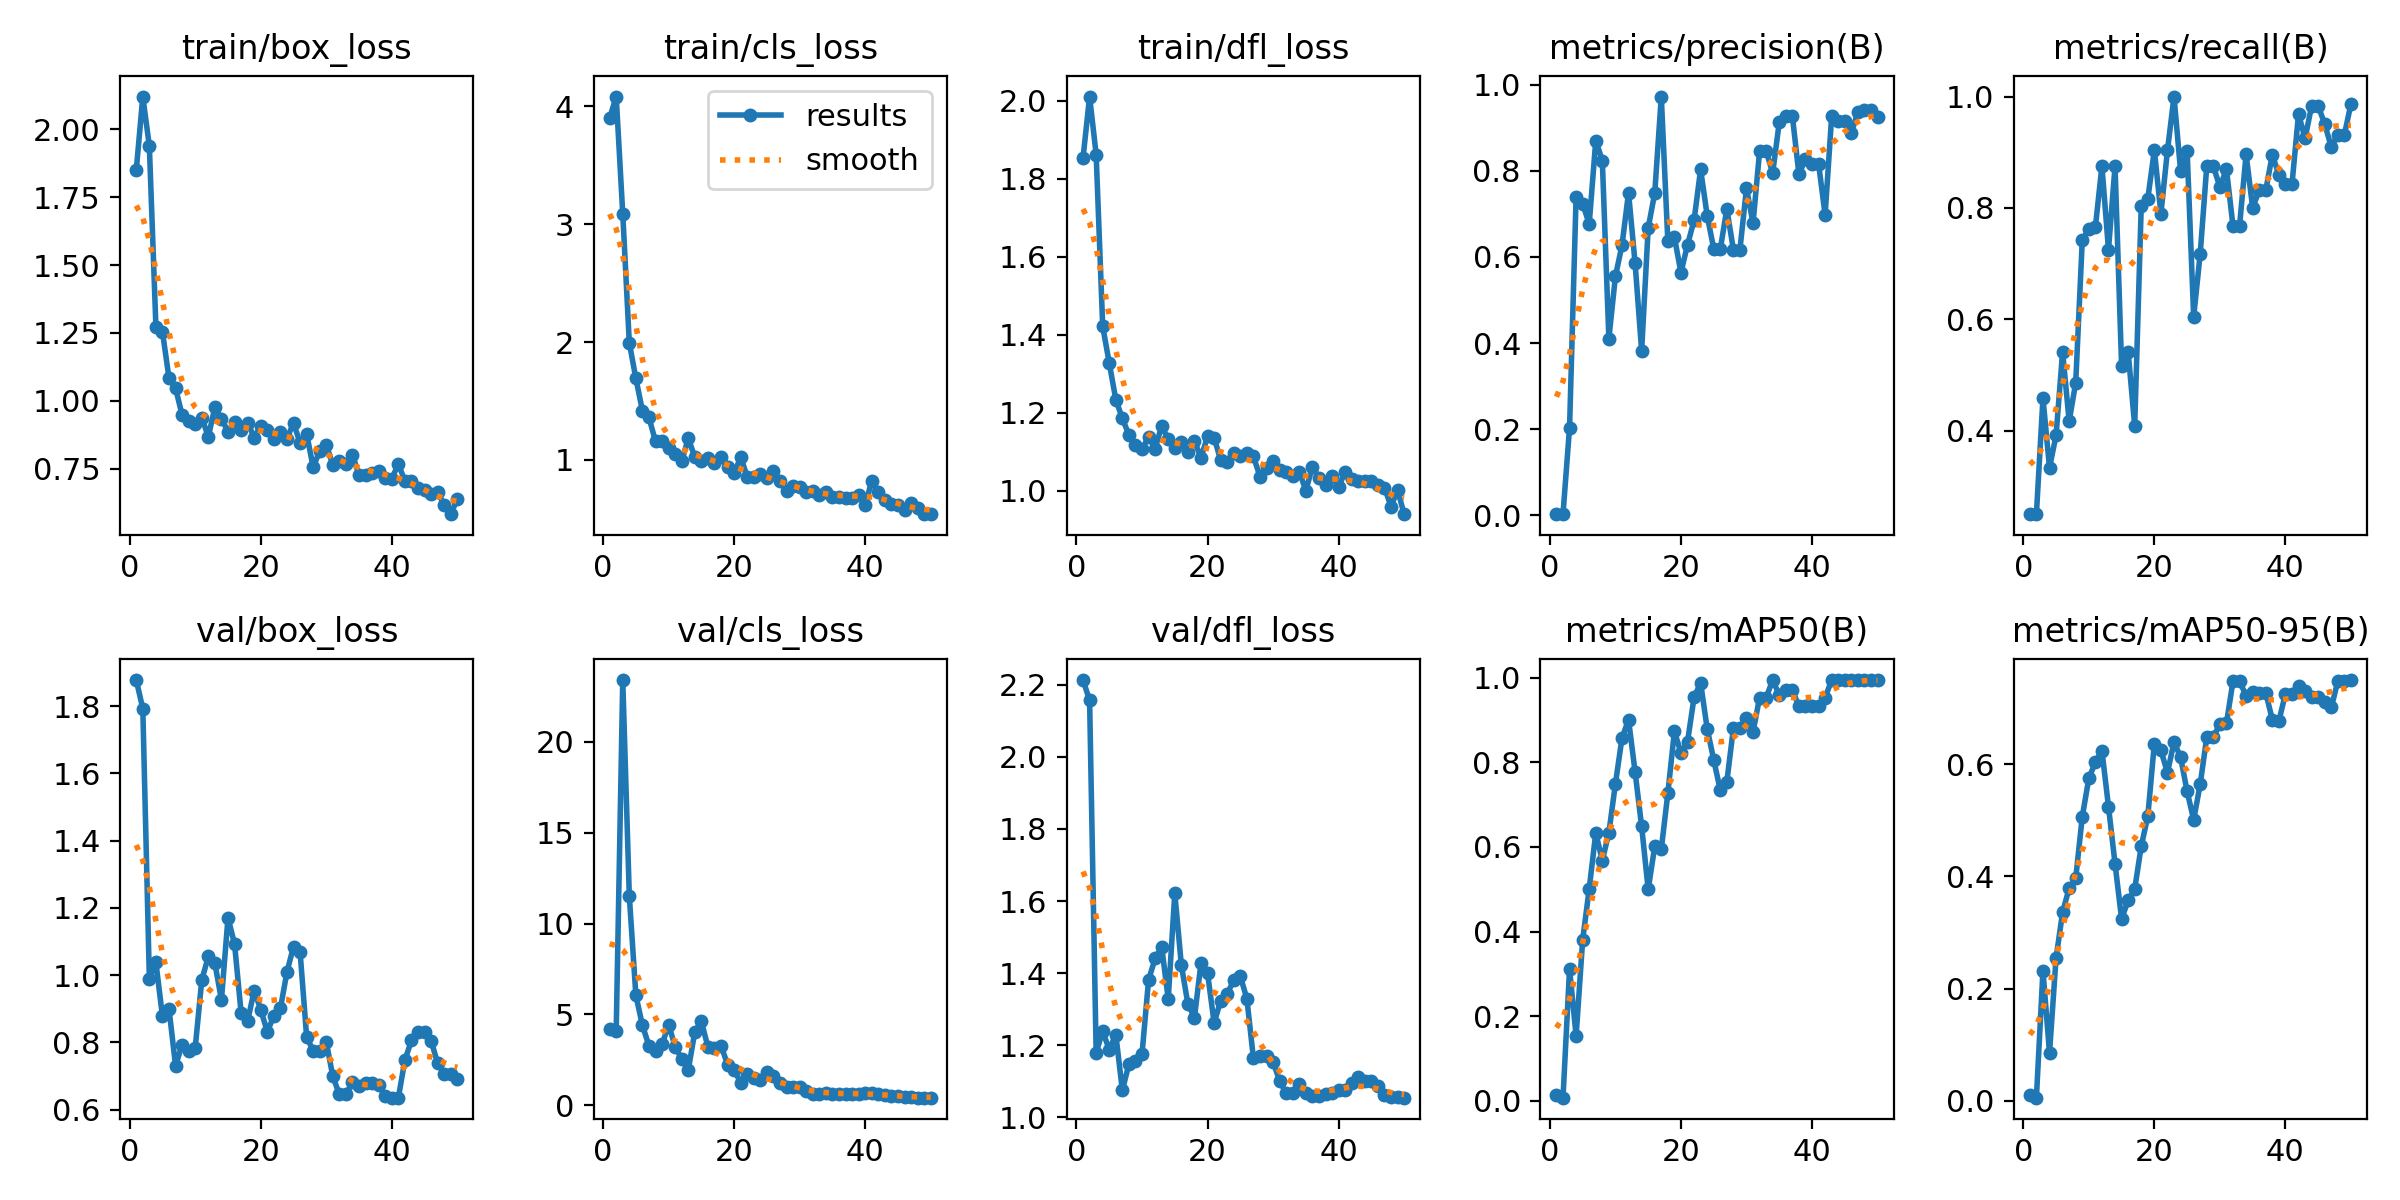

In [ ]:
res = Image.open('/content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/results.png')
display(res)

#### Training & Validation Metrics — Observations:
Loss Trends:
- train/box_loss:	Rapid initial drop and steady decrease toward convergence (starts at ~2.1 to ~0.7).
- train/cls_loss:	High at start (~4), decreases consistently, stabilizing around 0.7.
- train/dfl_loss:	Declines steadily from ~2.0 to ~1.0, showing good localization improvement.

Validation Loss:
- val/box_loss:	Decreases from ~1.8 to ~0.7 but shows slight fluctuation mid-way (some overfitting risk).
- val/cls_loss:	Sharp spike at epoch 2 (~22) then stabilizes below 5 — indicating early noise or imbalance.
- val/dfl_loss:	Gradual reduction with mild instability, but trends towards convergence.

Evaluation Metrics:
- metrics/precision(B):	Rises with variance but stabilizes around 0.9–1.0, indicating highly precise predictions.
- metrics/recall(B):	Gradually improves to nearly 1.0, indicating strong coverage of true positives.
- metrics/mAP50(B):	Improves consistently to ~0.95–1.0, indicating accurate object detection at IOU=0.5.
- metrics/mAP50-95(B):	Starts low but rises steadily to ~0.75, which reflects robust performance across varying IOU thresholds.

Key Insights:
- Model is learning well: All loss components decrease, and evaluation metrics improve significantly.
- Early overfitting signs: Some mid-epoch fluctuations in validation loss and mAP may hint at overfitting or label noise.
- High precision and recall: Final results show nearly perfect classification and detection capability.
- Sharp recovery from noisy early epochs, especially in val/cls_loss.

Plotting Precision and Recall Confidence curve

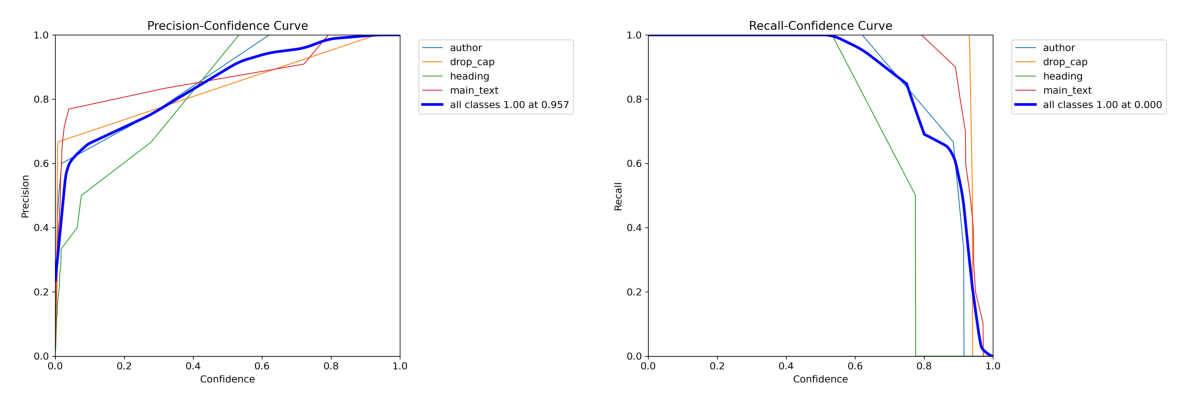

In [ ]:
P_curve = Image.open('/content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/P_curve.png')
R_curve = Image.open('/content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/R_curve.png')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(P_curve)
axes[0].axis('off')
axes[1].imshow(R_curve)
axes[1].axis('off')
plt.tight_layout()
plt.show()

#### Observations:
- main_text and drop_cap show consistently high precision across all confidence thresholds.
- heading class has lower precision at lower confidence values (<0.4), indicating occasional false positives.
- author starts with moderate precision but climbs steadily with increasing confidence.
- All Classes (bold blue line): Achieves 1.00 precision at confidence = 0.957, showing strong model certainty when confident.

Plotting mAP@0.5 & mAP@0.5:0.95 trends to track detection accuracy improvements over training

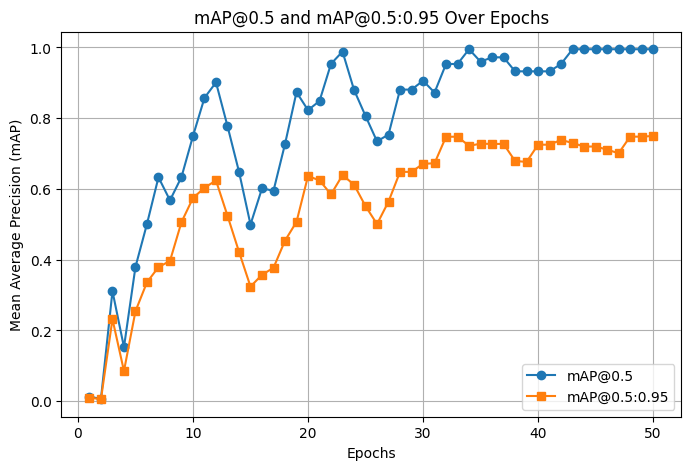

In [ ]:
results_path = "/content/drive/MyDrive/Lor_YOLO/yolo/runs/layout_detection_gpu/results.csv"
df = pd.read_csv(results_path)
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label="mAP@0.5", marker='o')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label="mAP@0.5:0.95", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Mean Average Precision (mAP)")
plt.title("mAP@0.5 and mAP@0.5:0.95 Over Epochs")
plt.legend()
plt.grid()
plt.show()

#### Observations:
mAP@0.5:
- Shows a steady and sharp rise until epoch 20.
- Peaks at 1.00 around epoch 38 and stays consistently perfect till epoch 50.
- Indicates excellent localization and class detection with lenient IoU.

mAP@0.5:0.95:
- Exhibits more fluctuation, which is expected due to stricter IoU averaging.
- Rises from near 0 to ~0.75 by epoch 50.
- The model shows significant improvements in precise localization over time.

### Next Steps

1. **Integrate with OCR Pipeline**  
   Use the detected layout regions (like `main_text`, `heading`, `drop_cap`, `author`) as input for a text recognition model (e.g., CRNN or TrOCR) to extract structured text.

2. **Train a Text Recognition Model**  
   Implement and fine-tune an OCR model such as:
   - **CRNN** for printed historical fonts.
   - **TrOCR** (Transformer-based OCR) for better handling of noisy or irregular texts.
   - Consider adding language modeling for post-processing.

3. **Experiment with Advanced Layout Models**  
   Try other layout detection models like:
   - **LayoutLMv3** (if using textual + visual features).
   - **Mask2Former + DINOv2** for segmentation-based layout recognition using pretrained ViT backbones.

4. **Enhance Dataset Quality & Quantity**  
   - Increase annotation variety (e.g., more samples of headings, drop caps).
   - Apply more data augmentation (like elastic distortion, blur, yellow tint) to mimic real-world printing defects.

5. **Post-processing & Structuring Output**  
   - Convert predictions into structured formats like **JSON, ALTO-XML**, or **TEI** for downstream historical text analysis or digital archiving.

6. **Deploy the Full Pipeline**  
   Build an end-to-end system that:
   - Accepts scanned historical pages.
   - Detects layout.
   - Extracts text.
   - Outputs cleaned and structured transcriptions.